In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn

from tqdm.notebook import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float
print(device)

torch.manual_seed(0)
np.random.seed(0)

cpu


In [2]:
hoop_location = torch.tensor([0, 0.8])

o_player_idxs = torch.arange(5)
d_player_idxs = torch.arange(5, 10)
ball_idxs = torch.tensor([10])

num_game_steps = 50


def random_initial_game_state(batch_size, only_game_state=True):
    opls = torch.rand(batch_size, len(o_player_idxs), 2)*2 - 1
    dpls = torch.rand(batch_size, len(d_player_idxs), 2)*2 - 1
    bls = torch.rand(batch_size, len(ball_idxs), 2)*2 - 1
    
    init_game_state = torch.cat((opls, dpls, bls), dim=1)
    
    if only_game_state:
        return init_game_state
    else:
        return init_game_state, opls, dpls, bls

# Game Visualization

In [3]:
def show_game_state(game_state, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,8)) # note we must use plt.subplots, not plt.subplot
    # (or if you have an existing figure)
#     fig = plt.gcf()
#     ax = fig.gca()
    
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    
    for o_player in o_player_idxs.numpy():
        x, y = game_state[o_player]
        circle = plt.Circle((x, y), radius = 0.05, color='b')
        ax.add_artist(circle)
    for d_player in d_player_idxs.numpy():
        x, y = game_state[d_player]
        circle = plt.Circle((x, y), radius = 0.05, color='r')
        ax.add_artist(circle)
    for ball in ball_idxs.numpy():
        x, y = game_state[ball]
        circle = plt.Circle((x, y), radius = 0.04, color='orange')
        ax.add_artist(circle)
    
    ax.add_artist(plt.Circle(hoop_location.numpy(), radius=0.1, color='orange', fill=False))
    
    ax.set_title('Game State')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
#     circle2 = plt.Circle((0.5, 0.5), 0.2, color='blue')
#     circle3 = plt.Circle((-1, 1), 0.2, color='g', clip_on=False)
    return ax
#     return fig

# Model Definitions

In [4]:
def get_dense_layers(num_features):
    acts = [torch.nn.LeakyReLU() for num_out in num_features[1:-1]]
    acts.append(torch.nn.Identity())
    layers = []
    for num_in, num_out, act in zip(num_features, num_features[1:], acts):
        layers.extend((torch.nn.Linear(num_in, num_out), act))
    return torch.nn.Sequential(*layers)

class OffenseModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.main = get_dense_layers([11*2, 100, 100, 6*2])
    def forward(self, X):
        X = X.view(-1, 11*2)
        X = self.main(X)
        X = torch.tanh(X)
        X = X.view(-1, 6, 2)
        return X
    
class DefenseModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.main = get_dense_layers([11*2, 100, 100, 5*2])
    def forward(self, X):
        X = X.view(-1, 11*2)
        X = self.main(X)
        X = 0.1 * torch.tanh(X)
        X = X.view(-1, 5, 2)
        return X
    
o_model = OffenseModel()
d_model = DefenseModel()


# Optimization

In [5]:
def loss_function(all_game_states):
    loss = 0.0
    for game_state in all_game_states:
        ls = game_state[:, torch.cat((o_player_idxs, d_player_idxs, ball_idxs)), :]

    
        r = torch.sqrt((ls[:, :, :] - hoop_location[None, None, :]).norm(dim=-1))
        ri = 1/torch.exp(r)
        
        loss += ri.mean()
#         loss = loss + dists.min(dim=-1).values.mean()
        
    return loss


In [6]:
def run_simulation(o_model, d_model, init_game_state, with_grad=False, pbar=None):
    all_game_states = [init_game_state]
    
    current_game_state = init_game_state
    with torch.set_grad_enabled(with_grad):
        
        if pbar is not None:
            pbar.reset(total=num_game_steps)
        for game_step in range(num_game_steps):
            o_move = o_model(current_game_state)
            d_move = d_model(current_game_state)

            current_game_state = current_game_state.clone()
            current_game_state[:, torch.cat((o_player_idxs, ball_idxs)), :] += o_move
            current_game_state[:, d_player_idxs, :] += d_move
            current_game_state = current_game_state.clamp(-1, 1)

            all_game_states.append(current_game_state)
            if pbar is not None:
                pbar.update()
    return all_game_states
        

Loss:  19.100723266601562


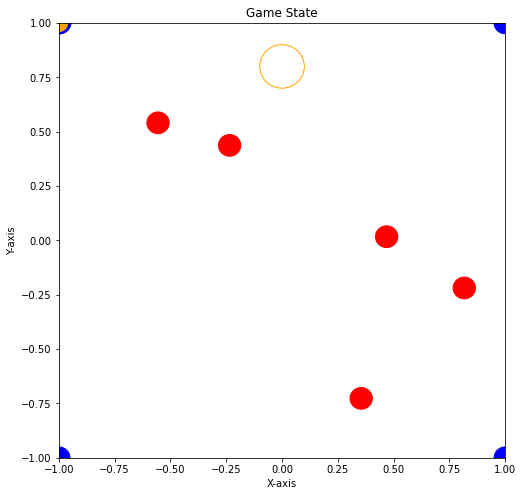

In [7]:
init_game_state = random_initial_game_state(batch_size=1)
all_game_states = run_simulation(o_model, d_model, init_game_state)

print('Loss: ', loss_function(all_game_states).item())
show_game_state(all_game_states[-1][0])
plt.show()

In [11]:
batch_size = 19

o_opt = torch.optim.Adam(o_model.parameters())
d_opt = torch.optim.Adam(d_model.parameters())

o_losses, d_losses = [], []


total_pbar = tqdm(range(1000), desc='Epochs')
game_pbar = tqdm(desc='Batch Game Simulation')

for epoch in total_pbar:
    init_game_state = random_initial_game_state(batch_size=batch_size)
    

    
#     show_game_state(game_state[0].detach().numpy())
    
    all_game_states = run_simulation(o_model, d_model, init_game_state, with_grad=True, pbar=game_pbar)
    
    o_opt.zero_grad()
    d_opt.zero_grad()
    loss = loss_function(all_game_states)
    loss.backward()
    
    for params in d_model.parameters(): 
        params.grad *= -1.0 # invert the gradient to maximize the loss
    o_opt.step()
    d_opt.step()
    
    loss = loss.item()
    
#     show_game_state(game_state[0].detach().numpy())
    print(loss)
    o_losses.append(loss)
    d_losses.append(-loss)
    

19.370885848999023
19.560850143432617
19.397672653198242
19.506072998046875
19.502580642700195
19.59237289428711
19.693851470947266
19.730649948120117
19.58269691467285
19.717315673828125
19.79074478149414
19.83089828491211
19.87195587158203
19.88399314880371
20.024944305419922
19.97795295715332
19.864065170288086
20.04657745361328
20.053565979003906
20.15530014038086
20.216821670532227
20.0069637298584
20.326480865478516
20.21249008178711
20.16207504272461
20.392126083374023
20.009035110473633
19.847000122070312
19.817916870117188
20.041988372802734
20.20703125
20.268539428710938
20.274028778076172
20.166032791137695
20.14345359802246
20.17714500427246
20.141376495361328
20.2990779876709
20.422557830810547
20.390579223632812
20.31850242614746
20.352191925048828
20.2852725982666
20.277936935424805
20.482330322265625
20.264232635498047
20.33121681213379
20.289478302001953
20.515701293945312
20.453031539916992
20.418249130249023
20.472251892089844
20.55654525756836
20.43718910217285
20.4

20.96837043762207
20.876068115234375
20.891969680786133
20.918167114257812
20.97615623474121
20.849628448486328
20.913074493408203
20.921003341674805
20.91180992126465
20.896106719970703
20.921476364135742
20.930492401123047
20.93130111694336
20.922456741333008
20.997146606445312
20.994958877563477
20.987232208251953
20.863689422607422
20.908342361450195
20.936342239379883
20.800649642944336
20.947893142700195
20.921932220458984
20.88446044921875
20.969261169433594
20.951574325561523
20.927507400512695
20.853145599365234
21.01961898803711
20.9466495513916
20.890666961669922
20.9766788482666
20.873050689697266
20.89833641052246
20.925247192382812
20.945146560668945
20.984569549560547
20.969093322753906
20.94146156311035
20.917476654052734
20.92902946472168
20.914695739746094
20.94838523864746
20.927804946899414
20.960439682006836
20.9268856048584
20.950180053710938
21.00075340270996
20.966835021972656
20.902280807495117
20.95463752746582
21.003067016601562
20.955764770507812
20.99011611

20.95768928527832
20.942277908325195
20.9681453704834
20.824684143066406
20.984548568725586
20.942344665527344
20.990386962890625
21.063636779785156
20.990341186523438
20.97505760192871
20.869760513305664
20.870534896850586
20.93292236328125
21.022680282592773
20.97787094116211
20.930604934692383
20.9426212310791
20.959247589111328
20.963058471679688
20.98589324951172
21.033578872680664
20.925851821899414
20.874155044555664
20.91518783569336
20.90282440185547
20.996458053588867
20.881855010986328
20.984071731567383
20.9426212310791
21.017467498779297
21.060914993286133
20.922903060913086
20.89493179321289
20.86922836303711
20.943635940551758
20.879474639892578
20.972990036010742
20.916446685791016
20.952245712280273
21.012435913085938
20.978515625
20.933887481689453
21.042051315307617
20.854589462280273
20.889543533325195
21.004823684692383
20.995073318481445
20.947154998779297
20.891382217407227
20.891101837158203
20.952775955200195
20.9859676361084
21.002906799316406
21.0537891387939

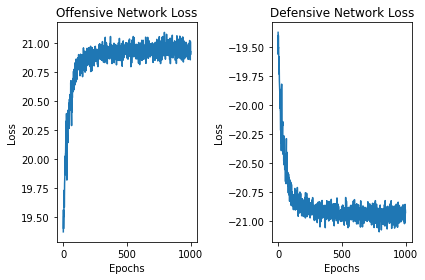

In [12]:
plt.subplot(121)
plt.plot(np.arange(len(o_losses)), o_losses)
plt.title('Offensive Network Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(122)
plt.plot(np.arange(len(d_losses)), d_losses)
plt.title('Defensive Network Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

Loss:  20.7391300201416


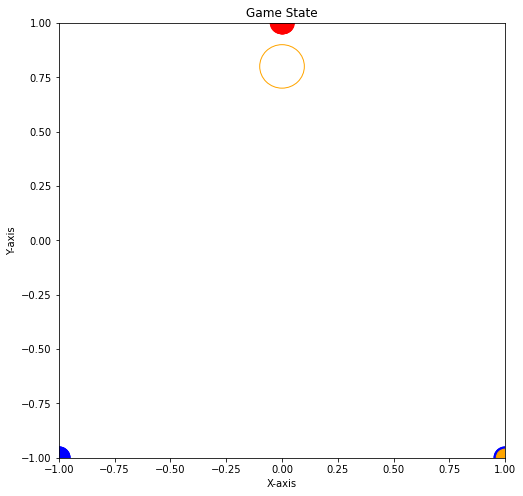

In [14]:
init_game_state = random_initial_game_state(batch_size=1)
all_game_states = run_simulation(o_model, d_model, init_game_state)

print('Loss: ', loss_function(all_game_states).item())
show_game_state(all_game_states[-1][0])
plt.show()

# Loss Function Visuals

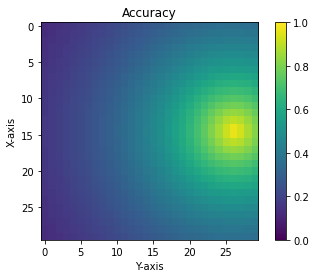

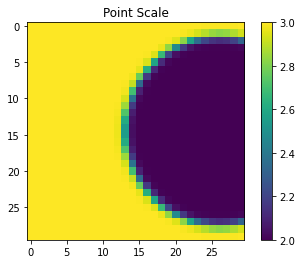

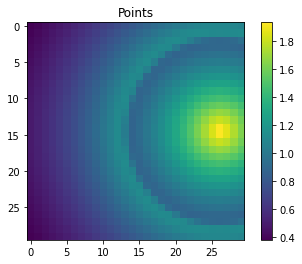

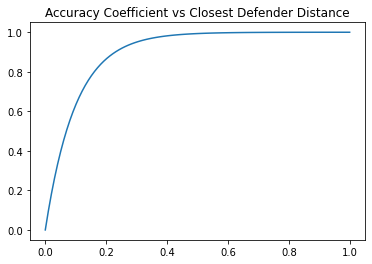

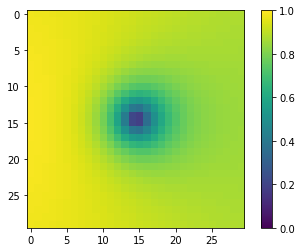

In [11]:
resolution = 30

x, y = torch.meshgrid(torch.linspace(-1, 1, resolution), torch.linspace(-1,1, resolution))
r = torch.sqrt((x-hoop_location[0])**2+(y-hoop_location[1])**2)
ri = 1/torch.exp(r)
theta = torch.atan2(y, x)



# plt.imshow(np.log(ri), cmap='gray')
# plt.show()

accuracy = ri
plt.imshow(accuracy, vmin=0, vmax=1)
plt.xlabel('Y-axis')
plt.ylabel('X-axis')
plt.title('Accuracy')
plt.colorbar()
plt.show()

point_scale = 2*torch.ones((resolution, resolution)) + 1 / (1 + torch.exp(-50 * (r-0.9)))

plt.imshow(point_scale)
plt.title('Point Scale')
plt.colorbar()
plt.show()


plt.imshow(point_scale*accuracy)
plt.title('Points')
plt.colorbar()
plt.show()


d = torch.linspace(0, 1, 100)
contest = 1 - torch.exp(-10*d)
plt.plot(d, contest)
plt.title('Accuracy Coefficient vs Closest Defender Distance')
plt.show()



r = torch.sqrt((x)**2+(y)**2)
contest = 1 - torch.exp(-5*r)

direction = (torch.cos(theta+0.5*np.pi)+13.)/14.

plt.imshow(direction*contest, vmin=0, vmax=1)
plt.colorbar()
plt.show()


